In [1]:
import os 
import math
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

C:\Users\nicol\AppData\Local\Temp\ipykernel_27052\2104189548.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Read csv with pandas

In [2]:
students_mat = pd.read_csv(os.path.join('data','student-mat.csv'))
students_por = pd.read_csv(os.path.join('data','student-por.csv'))

In [3]:
students = pd.concat([students_mat, students_por], axis=0)
students

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,services,other,...,5,4,2,1,2,5,4,10,11,10
645,MS,F,18,U,LE3,T,3,1,teacher,services,...,4,3,4,1,1,1,4,15,15,16
646,MS,F,18,U,GT3,T,1,1,other,other,...,1,1,1,1,1,5,6,11,12,9
647,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,6,10,10,10


In [4]:
#Averaging three grades into one single grade
students['grade'] = (students['G1'] + students['G2'] + students['G3']) / 3
#Combining weekly and weekend alcohol comsumption into a single attribute 
students['alcohol_comsump'] = students['Walc'] + students['Dalc']
#Drop the combined columns
students = students.drop(columns=['G1','G2','G3','school'], axis=0)

In [5]:
students.head(5)

,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,...,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,grade,alcohol_comsump
0,F,18,U,GT3,A,4,4,at_home,teacher,course,...,no,4,3,4,1,1,3,6,5.666667,2
1,F,17,U,GT3,T,1,1,at_home,other,course,...,no,5,3,3,1,1,3,4,5.333333,2
2,F,15,U,LE3,T,1,1,at_home,other,other,...,no,4,3,2,2,3,3,10,8.333333,5
3,F,15,U,GT3,T,4,2,health,services,home,...,yes,3,2,2,1,1,5,2,14.666667,2
4,F,16,U,GT3,T,3,3,other,other,home,...,no,4,3,2,1,2,5,4,8.666667,3


# Transform string to categorical values

### LabelEncoder()

Permite converter dados categóricos ou em formato de texto para *valores númericos*. O importante é que deve ser usado nos "target values" e não nos inputs X.
<br><br>
**Obs:** Nós queremos transformar apenas os dados categóricos em números, não faz sentido fazermos isso em dados já números, isso pode gerar problemas e perda de informação.

In [6]:
categorical_dict = {}
for col in students.columns:
    # Para cada coluna do tipo "object", usaremos o label encoder e adicionar o mapeamento a um dicionário.
    if students[col].dtype == 'object':
        # Criação da variável que recebe o LabelEncoder
        le = LabelEncoder()
        students[col] = le.fit_transform(students[col])
        categorical_dict[col] = dict(zip(le.classes_,le.transform(le.classes_)))

In [7]:
# Print do dicionário com as labels categóricas
pprint(categorical_dict)

{'Fjob': {'at_home': 0, 'health': 1, 'other': 2, 'services': 3, 'teacher': 4},
 'Mjob': {'at_home': 0, 'health': 1, 'other': 2, 'services': 3, 'teacher': 4},
 'Pstatus': {'A': 0, 'T': 1},
 'activities': {'no': 0, 'yes': 1},
 'address': {'R': 0, 'U': 1},
 'famsize': {'GT3': 0, 'LE3': 1},
 'famsup': {'no': 0, 'yes': 1},
 'guardian': {'father': 0, 'mother': 1, 'other': 2},
 'higher': {'no': 0, 'yes': 1},
 'internet': {'no': 0, 'yes': 1},
 'nursery': {'no': 0, 'yes': 1},
 'paid': {'no': 0, 'yes': 1},
 'reason': {'course': 0, 'home': 1, 'other': 2, 'reputation': 3},
 'romantic': {'no': 0, 'yes': 1},
 'schoolsup': {'no': 0, 'yes': 1},
 'sex': {'F': 0, 'M': 1}}


## Correlation heatmap

<Axes: >

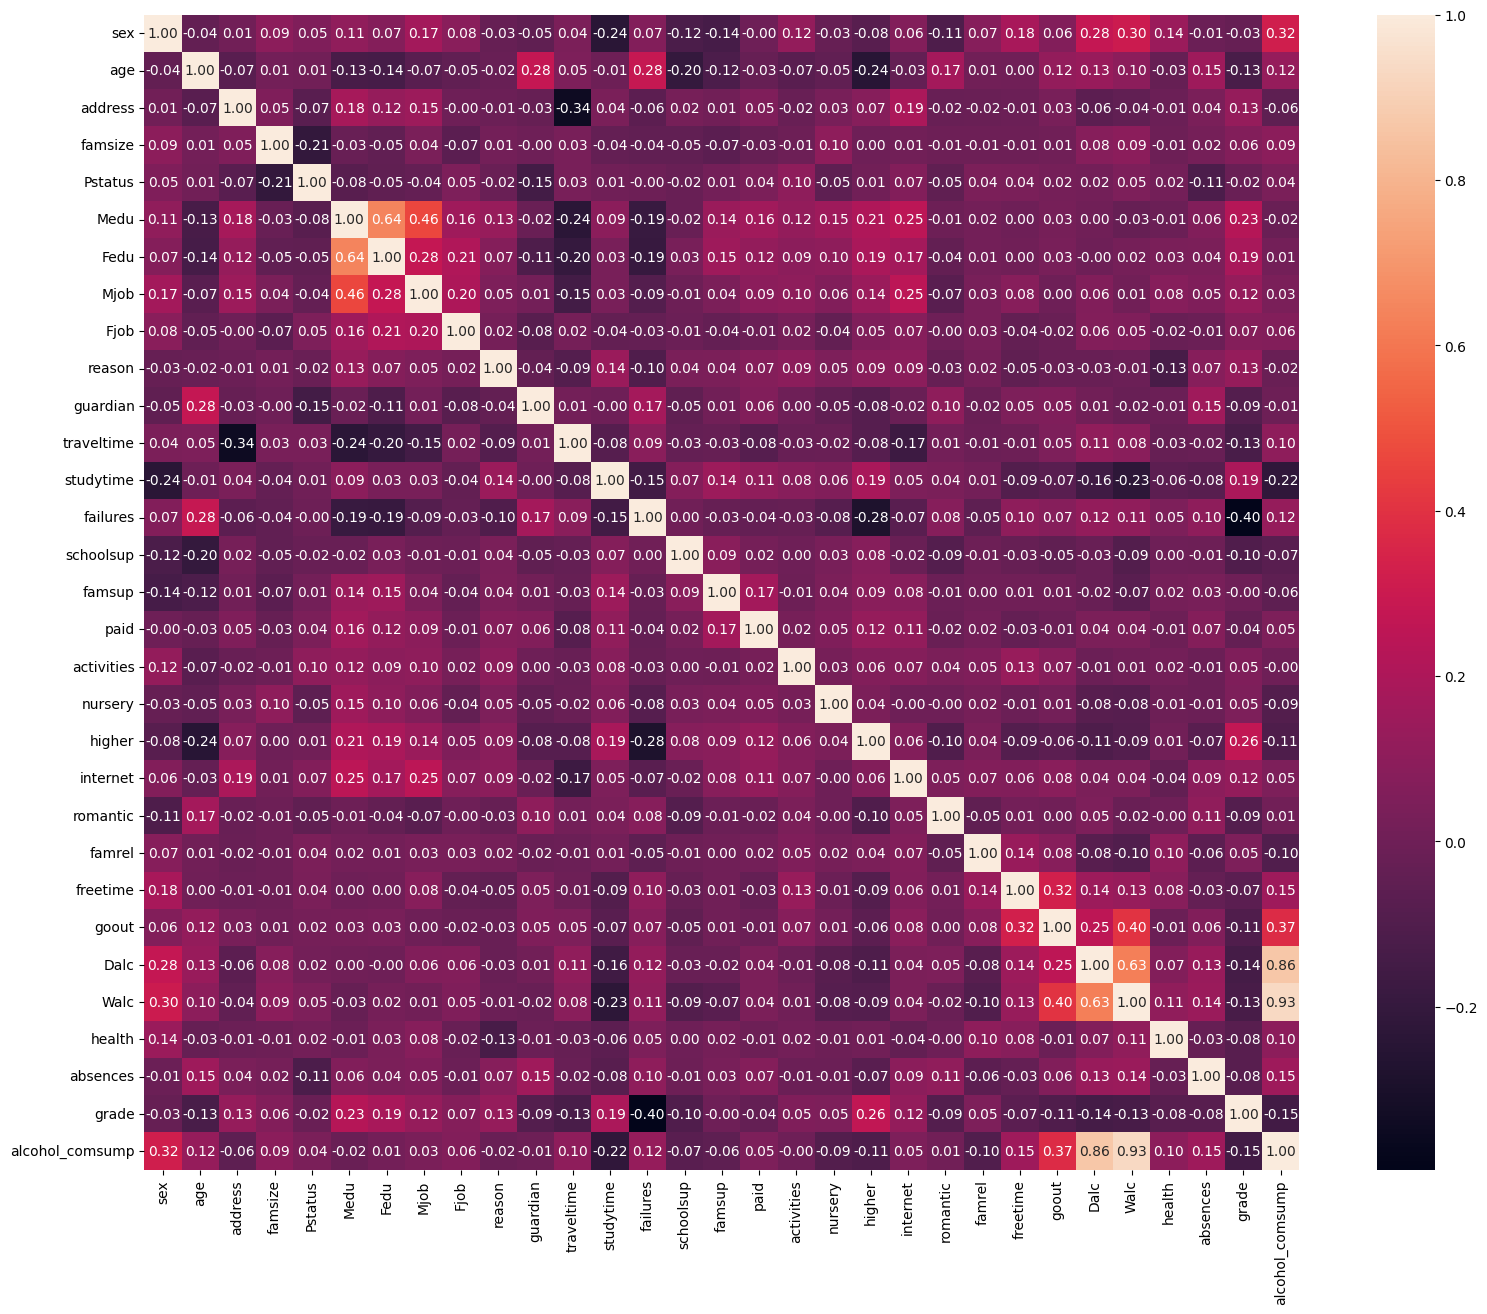

In [8]:
plt.figure(figsize=(20,15))
sns.heatmap(students.corr(), annot=True, square=True, fmt='0.2f')

Analisando o heatmap, podemos ter uma visão geral de como o álcool impacta a vida dos estudantes. Baseando a correlação linear entre o target e as features, para os estudantes que consomem álcool frequentemente, eles tem mais chance de:

- Ter menores notas
- Terem mais faltas
- Sair com mais frequência
- Não tem objetivo de alcançar o ensino superior
- Estudam menos